# LOSO 검증 결과 분석

`checkpoints/loso_ss`에 저장된 LOSO fold별 결과를 불러와서 성능 지표, 요약 통계, 클래스별 지표, 시각화를 한 번에 확인할 수 있는 노트북입니다.


In [ ]:
from pathlib import Path
import json

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

sns.set_theme(style="whitegrid", context="notebook")

NOTEBOOK_DIR = Path.cwd()
if (NOTEBOOK_DIR / "checkpoints").exists():
    PROJECT_ROOT = NOTEBOOK_DIR
elif (NOTEBOOK_DIR.parent / "checkpoints").exists():
    PROJECT_ROOT = NOTEBOOK_DIR.parent
else:
    raise FileNotFoundError("checkpoints 디렉터리를 찾을 수 없습니다. 노트북 위치를 확인하세요.")

CHECKPOINT_DIR = PROJECT_ROOT / "checkpoints" / "loso_ss"
CLASS_LABELS = {
    0: "Correct",
    1: "Knee Valgus",
    2: "Butt Wink",
    3: "Excessive Lean",
    4: "Partial Squat",
}

print(f"분석 대상 디렉터리: {CHECKPOINT_DIR}")


분석 대상 디렉터리: /Users/Jae/Projects/Squat-Realtime-Classifier/squat_classifier_ssl/checkpoints/loso_ss_focalyes


In [2]:
subject_dirs = sorted(
    [p for p in CHECKPOINT_DIR.iterdir() if p.is_dir() and p.name.startswith("subject")],
    key=lambda p: int(p.name.replace("subject", "")),
)

fold_records = []
class_records = []
missing_reports = []

for subject_dir in subject_dirs:
    subject_id = subject_dir.name
    report_files = sorted(subject_dir.glob("classification_report*.json"))
    if not report_files:
        missing_reports.append(subject_id)
        continue

    with open(report_files[0], "r") as f:
        report = json.load(f)

    macro_avg = report.get("macro avg", {})
    accuracy = report.get("accuracy", np.nan)
    macro_precision = macro_avg.get("precision", np.nan)
    macro_recall = macro_avg.get("recall", np.nan)
    macro_f1 = macro_avg.get("f1-score", np.nan)

    fold_records.append(
        {
            "subject": subject_id,
            "Accuracy": accuracy,
            "Macro Precision": macro_precision,
            "Macro Recall": macro_recall,
            "Macro F1": macro_f1,
            "Balanced Accuracy": macro_recall,
        }
    )

    for cls_key, metrics in report.items():
        if not cls_key.isdigit():
            continue
        cls_id = int(cls_key)
        class_records.append(
            {
                "subject": subject_id,
                "class_id": cls_id,
                "class_name": CLASS_LABELS.get(cls_id, f"Class {cls_id}"),
                "precision": metrics.get("precision", np.nan),
                "recall": metrics.get("recall", np.nan),
                "f1": metrics.get("f1-score", np.nan),
                "support": metrics.get("support", np.nan),
            }
        )

fold_df = pd.DataFrame(fold_records).set_index("subject").sort_index()
class_df = pd.DataFrame(class_records)

print(f"총 {len(fold_df)}개 subject 로드 완료")
if missing_reports:
    print("Missing reports:", ", ".join(missing_reports))


총 6개 subject 로드 완료


## 1. LOSO Fold별 성능 표
Accuracy, Macro F1, Balanced Accuracy(=클래스별 recall 평균)을 정리했습니다.


In [3]:
fold_metrics = fold_df[["Accuracy", "Macro F1", "Balanced Accuracy"]].copy()
display(fold_metrics.style.format("{:.3f}"))


,Accuracy,Macro F1,Balanced Accuracy
subject,,,
subject1,0.740,0.674,0.740
subject2,0.680,0.666,0.680
subject3,0.780,0.778,0.780
subject4,0.800,0.783,0.800
subject5,0.720,0.694,0.720
subject6,0.850,0.849,0.850


## 2. 전체 통계 요약
각 지표에 대해 mean ± std, 최악/최고 subject 정보를 제공합니다.


In [4]:
def summarize_metric(df: pd.DataFrame, metric: str) -> dict:
    values = df[metric]
    return {
        "Metric": metric,
        "Mean": values.mean(),
        "Std": values.std(ddof=1),
        "Mean ± Std": f"{values.mean():.4f} ± {values.std(ddof=1):.4f}",
        "Min (worst subject)": f"{values.min():.4f} ({values.idxmin()})",
        "Max (best subject)": f"{values.max():.4f} ({values.idxmax()})",
    }

summary_table = pd.DataFrame(
    [summarize_metric(fold_metrics, metric) for metric in fold_metrics.columns]
)
display(summary_table)


,Metric,Mean,Std,Mean ± Std,Min (worst subject),Max (best subject)
0,Accuracy,0.761667,0.060800,0.7617 ± 0.0608,0.6800 (subject2),0.8500 (subject6)
1,Macro F1,0.740603,0.073646,0.7406 ± 0.0736,0.6662 (subject2),0.8486 (subject6)
2,Balanced Accuracy,0.761667,0.060800,0.7617 ± 0.0608,0.6800 (subject2),0.8500 (subject6)


## 3. 클래스별 Precision / Recall / F1 (전체 피험자 평균)


In [5]:
class_avg = (
    class_df.groupby(["class_id", "class_name"])[["precision", "recall", "f1"]]
    .mean()
    .reset_index()
    .sort_values("class_id")
)
display(class_avg.style.format({"precision": "{:.3f}", "recall": "{:.3f}", "f1": "{:.3f}"}))


,class_id,class_name,precision,recall,f1
0,0,Correct,0.733,0.725,0.684
1,1,Knee Valgus,0.943,0.950,0.945
2,2,Butt Wink,0.869,0.767,0.763
3,3,Excessive Lean,0.625,0.450,0.477
4,4,Partial Squat,0.811,0.917,0.835


## 4. 피험자별 클래스 F1 표 & 히트맵


class_name,Correct,Knee Valgus,Butt Wink,Excessive Lean,Partial Squat
subject,,,,,
subject1,0.833,0.950,0.930,0.000,0.656
subject2,0.585,0.923,0.400,0.500,0.923
subject3,0.600,0.952,0.872,0.679,0.788
subject4,0.711,1.000,0.872,0.483,0.851
subject5,0.581,0.895,0.714,0.462,0.816
subject6,0.792,0.952,0.788,0.737,0.974


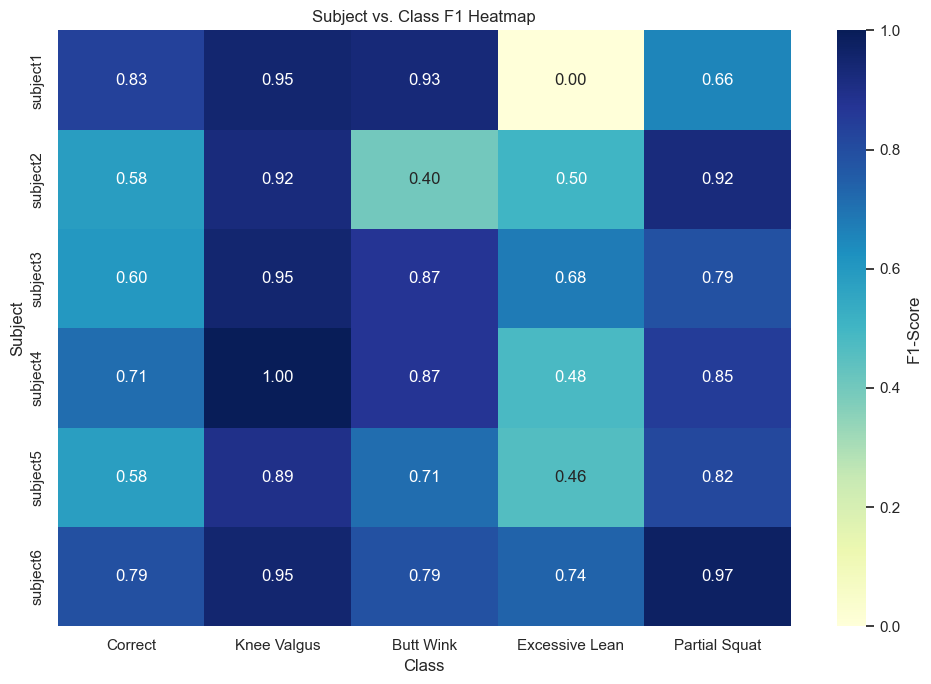

In [6]:
class_order = [CLASS_LABELS[k] for k in sorted(CLASS_LABELS.keys())]
subject_class_f1 = (
    class_df.pivot(index="subject", columns="class_name", values="f1")
    .reindex(fold_metrics.index)
    [class_order]
)

display(subject_class_f1.style.format("{:.3f}"))

plt.figure(figsize=(10, 4 + len(subject_class_f1) * 0.5))
sns.heatmap(
    subject_class_f1,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    vmin=0,
    vmax=1,
    cbar_kws={"label": "F1-Score"},
)
plt.title("Subject vs. Class F1 Heatmap")
plt.ylabel("Subject")
plt.xlabel("Class")
plt.tight_layout()
plt.show()


## 5. 피험자별 전반 성능 (Macro F1) Barplot


/var/folders/0n/7vdbl7ts6yl2vrl7hv5t30m80000gn/T/ipykernel_27151/2801205500.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_df, x="subject", y="Macro F1", palette="Blues_d")


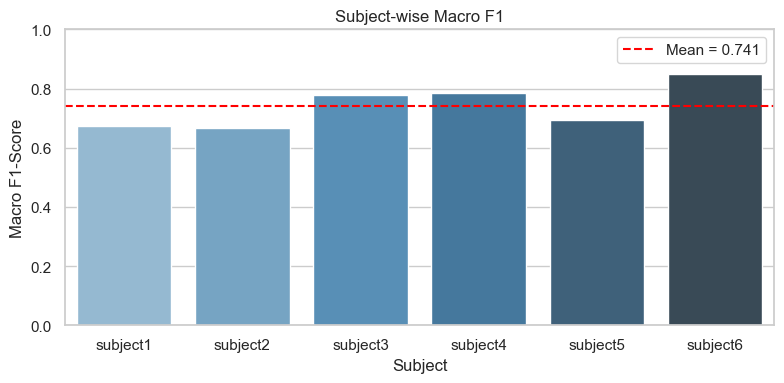

In [7]:
macro_f1_mean = fold_metrics["Macro F1"].mean()
plot_df = fold_metrics.reset_index()

plt.figure(figsize=(8, 4))
sns.barplot(data=plot_df, x="subject", y="Macro F1", palette="Blues_d")
plt.axhline(macro_f1_mean, color="red", linestyle="--", label=f"Mean = {macro_f1_mean:.3f}")
plt.ylim(0, 1)
plt.ylabel("Macro F1-Score")
plt.xlabel("Subject")
plt.title("Subject-wise Macro F1")
plt.legend()
plt.tight_layout()
plt.show()


## 6. LOSO 전체 Confusion Matrix
모든 fold의 `sample_predictions.csv`를 합쳐 구성했습니다.


,Correct,Knee Valgus,Butt Wink,Excessive Lean,Partial Squat
Correct,87,1,15,12,5
Knee Valgus,2,114,2,2,0
Butt Wink,19,2,92,7,0
Excessive Lean,26,1,6,54,33
Partial Squat,1,3,0,6,110


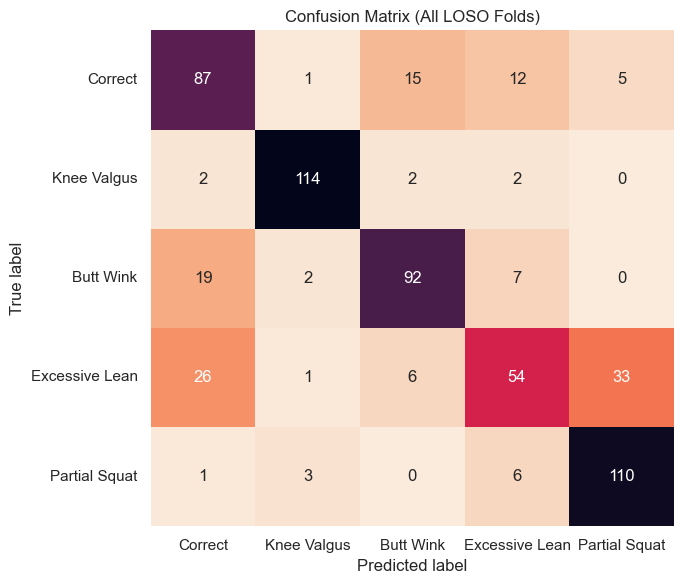

In [8]:
prediction_frames = []
for subject_dir in subject_dirs:
    csv_path = subject_dir / "sample_predictions.csv"
    if csv_path.exists():
        df = pd.read_csv(csv_path)
        df["subject"] = subject_dir.name
        prediction_frames.append(df)

if not prediction_frames:
    raise FileNotFoundError("sample_predictions.csv 파일을 찾을 수 없습니다.")

predictions = pd.concat(prediction_frames, ignore_index=True)
predictions["true_idx"] = predictions["true_idx"].astype(int)
predictions["pred_idx"] = predictions["pred_idx"].astype(int)

class_ids = sorted(CLASS_LABELS.keys())
conf_matrix = (
    pd.crosstab(predictions["true_idx"], predictions["pred_idx"])
    .reindex(index=class_ids, columns=class_ids, fill_value=0)
)
conf_matrix.index = [CLASS_LABELS[i] for i in class_ids]
conf_matrix.columns = conf_matrix.index

display(conf_matrix)

plt.figure(figsize=(7, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="rocket_r", cbar=False)
plt.title("Confusion Matrix (All LOSO Folds)")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()


## 7. 클래스별 F1 Barplot


/var/folders/0n/7vdbl7ts6yl2vrl7hv5t30m80000gn/T/ipykernel_27151/3501219971.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=class_avg, x="class_name", y="f1", palette="viridis")


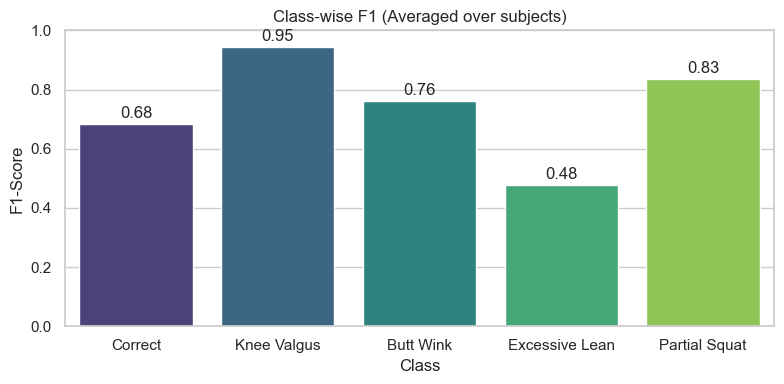

In [9]:
plt.figure(figsize=(8, 4))
sns.barplot(data=class_avg, x="class_name", y="f1", palette="viridis")
plt.ylim(0, 1)
plt.ylabel("F1-Score")
plt.xlabel("Class")
plt.title("Class-wise F1 (Averaged over subjects)")
for idx, value in enumerate(class_avg["f1"]):
    plt.text(idx, value + 0.01, f"{value:.2f}", ha="center", va="bottom")
plt.tight_layout()
plt.show()
